# Project: Classification

In [405]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
import sys
import warnings
warnings.filterwarnings('ignore')

from sklearn import ensemble 
from sklearn import linear_model 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn import tree 
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing  import LabelEncoder

sys.path.append('../../')

from DataScienceHelpers.DataCleaningOutliers import find_outliers_iqr
from DataScienceHelpers.DataCleaningOutliers import find_parameters_iqr


## Part 1. Getting to know the data, handling empy data and outliers

### Task 1

In [406]:
# Load data.
df = pd.read_csv('../../data/bank_fin.csv', sep = ';')
print(f'Rows: {df.shape[0]}')
print(f'Cols: {df.shape[1]}')

Rows: 11162
Cols: 17


In [407]:
# Investigate data for empty values. Which columns contains empty values? How many empty values are there?
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Task 2

In [408]:
# Are there empty values in the 'job' and 'education' features?
print('Job values by frequency:')
print(df['job'].value_counts())
print('Education by frequency:')
print(df['education'].value_counts())

Job values by frequency:
job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64
Education by frequency:
education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64


Empty values in the fields 'job' and 'education' are marked with the word 'unknown'.

### Task 3

In [409]:
# Convert the 'balance' feature to the float datatype.
def clean_up_balance(x):
    return x if pd.isna(x) else float(str(x)[:-3].replace(' ', '').replace(',', '.'))

df['balance'] = df['balance'].apply(lambda x: clean_up_balance(x))
print(f'Mean balance value: {df['balance'].mean():.3f}')

Mean balance value: 1529.129


### Task 4

In [410]:
# Process the empty values in the 'balance' feature by replacing them with the median value.
median_balance = df['balance'].median()
print(f'Median balance value: {median_balance:.3f}')

df['balance'] = df['balance'].apply(lambda x: median_balance if pd.isna(x) else x)
print(f'Updated mean balance value: {df['balance'].mean():.3f}')

Median balance value: 550.000
Updated mean balance value: 1526.936


### Task 5

In [411]:
# Process empty values in the features 'job' and 'education' by replacing them with the mode value.
job_mode = df['job'].value_counts().index.tolist()[0]
print(f'Job mode value: {job_mode}')

education_mode = df['education'].value_counts().index.tolist()[0]
print(f'Education mode value: {education_mode}')

df['job'] = df['job'].apply(lambda x: job_mode if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: education_mode if x == 'unknown' else x)

mask_popular_job_education = (df['job'] == job_mode) & (df['education'] == education_mode)
print(f'Mean balance for most popular job and education: {df[mask_popular_job_education]['balance'].mean():.3f}')


Job mode value: management
Education mode value: secondary
Mean balance for most popular job and education: 1598.883


### Task 6

In [412]:
# Delete outliers for the 'balance' feature
print('IQR, lower bound and upper bound found by the Tukey method:')
print(find_parameters_iqr(df, 'balance'))

outliers, df = find_outliers_iqr(df, 'balance')

print(f'Rows without outliers: {df.shape[0]}')

IQR, lower bound and upper bound found by the Tukey method:
(1576.0, -2241.0, 4063.0)
Rows without outliers: 10105


## Part 2: Exploratory data analysis

### Task 1

Value counts for the 'deposit' feature:
deposit
no     5424
yes    4681
Name: count, dtype: int64


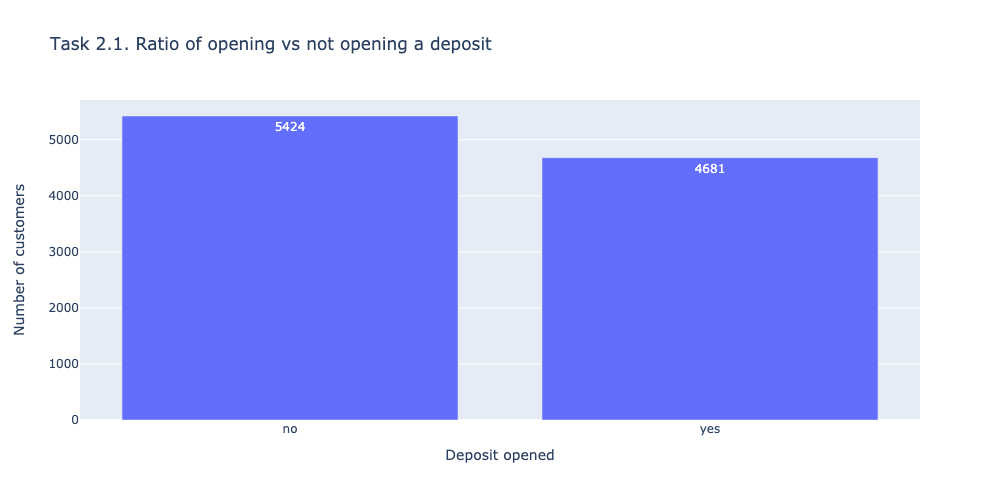

In [413]:
# Investigate the ratio of those who opened a deposit and those who did not do it. Illustrate your results.
print('Value counts for the \'deposit\' feature:')
print(df['deposit'].value_counts())

fig = px.bar(
    df['deposit'].value_counts(),    
    width=1000,
    height=500,
    title='Task 2.1. Ratio of opening vs not opening a deposit',
    text_auto=True
).update_layout(
    yaxis_title='Number of customers',
    xaxis_title='Deposit opened',
    showlegend=False
)
fig.show('png')

The data is slightly imbalanced showing the difference in classes of around 15 %.

### Tasks 2 and 3

In [414]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no


Quantitative statistics of the numeric features:
                age       balance           day      duration      campaign  \
count  10105.000000  10105.000000  10105.000000  10105.000000  10105.000000   
mean      40.895497    807.653538     15.590302    368.742603      2.517170   
std       11.734931    994.151966      8.441510    346.651524      2.707159   
min       18.000000  -2049.000000      1.000000      2.000000      1.000000   
25%       32.000000     95.000000      8.000000    137.000000      1.000000   
50%       38.000000    445.000000     15.000000    252.000000      2.000000   
75%       48.000000   1227.000000     22.000000    490.000000      3.000000   
max       95.000000   4063.000000     31.000000   3881.000000     43.000000   

              pdays      previous  
count  10105.000000  10105.000000  
mean      51.319644      0.816230  
std      109.644179      2.243795  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000    

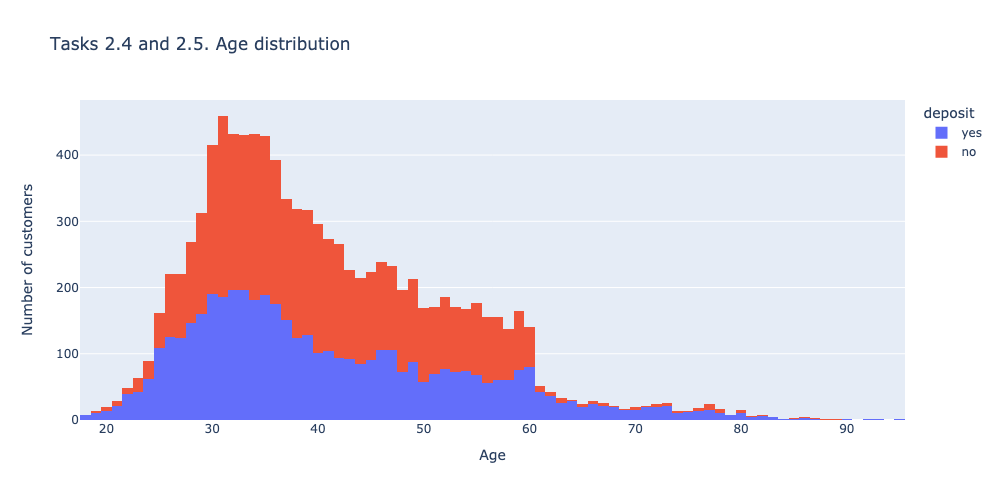

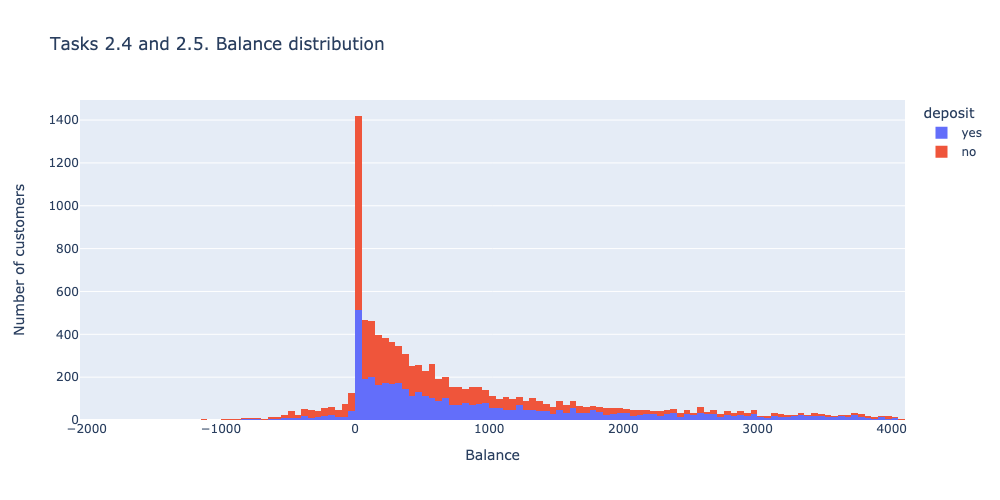

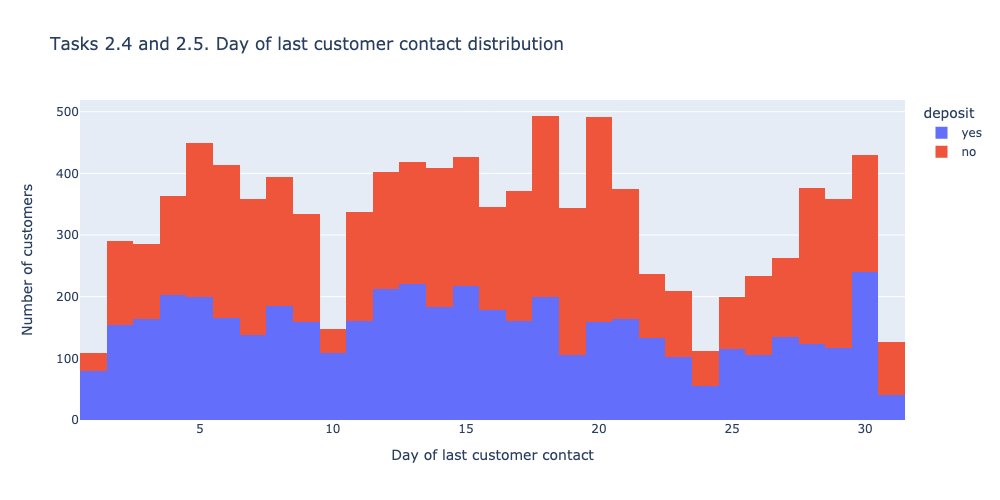

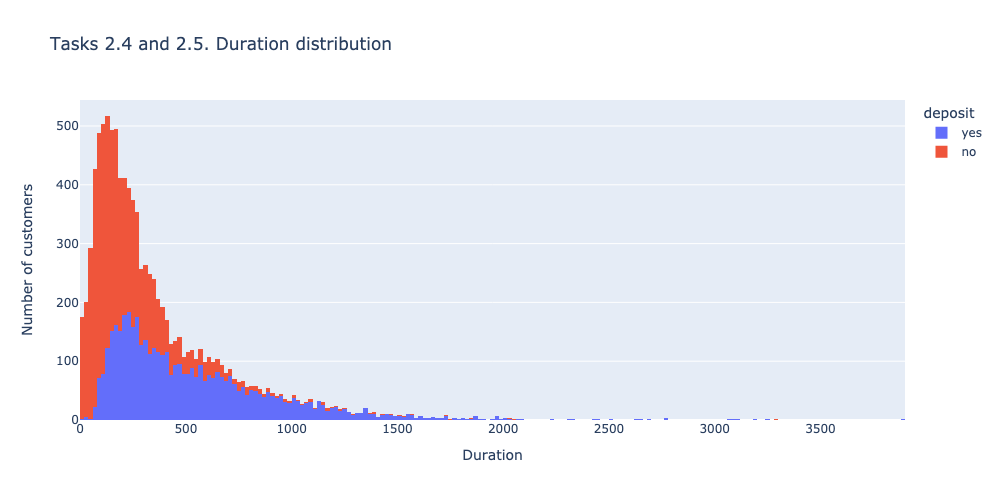

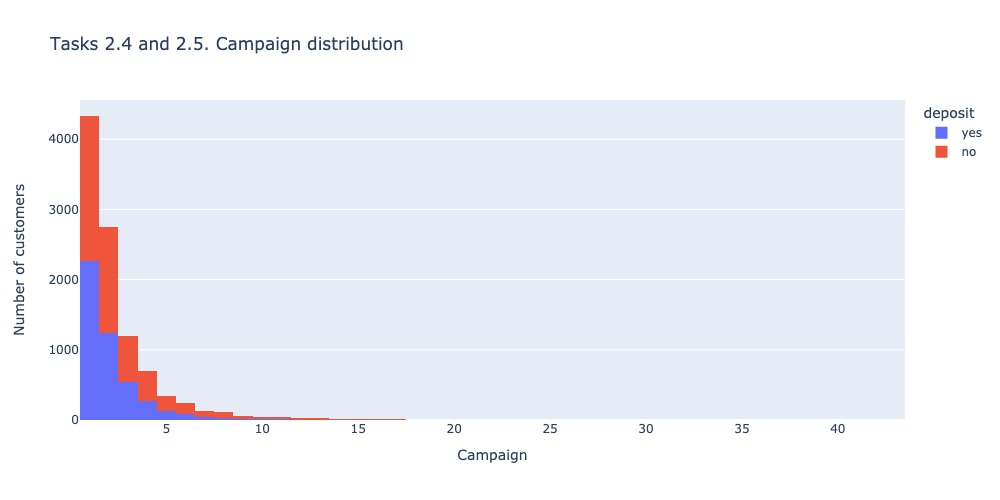

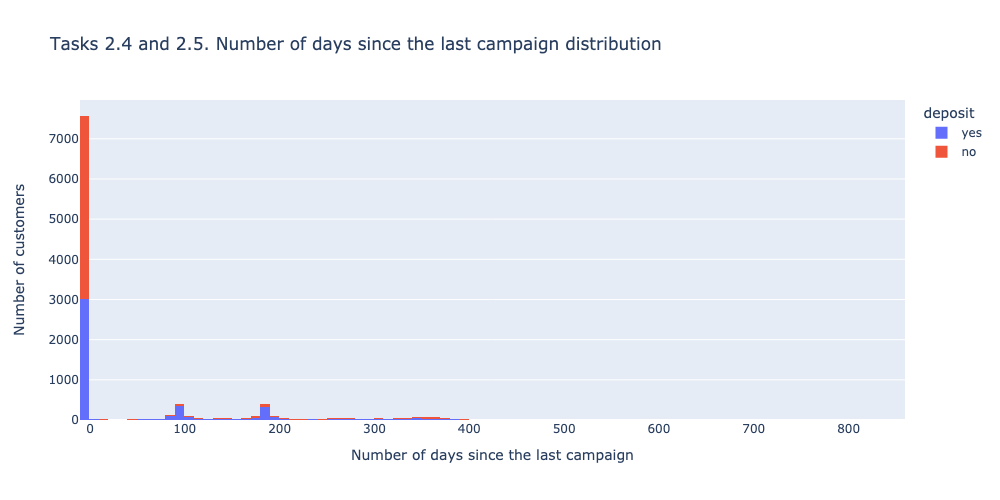

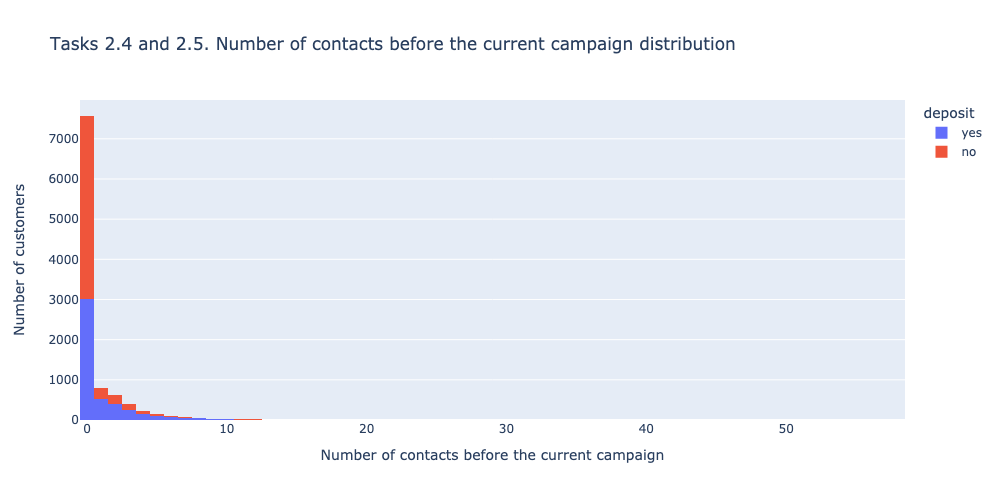

In [415]:
# Calculate quantitative statistics for numeric features. Interpret the results.
print('Quantitative statistics of the numeric features:')
print(df.describe())

def show_histogram(df, feature, feature_title, category_orders=None):
    fig = px.histogram(
        df,
        x=feature,
        color='deposit',
        category_orders=category_orders,
        width=1000,
        height=500,
        title=f'Tasks 2.4 and 2.5. {feature_title} distribution'
    ).update_layout(
        yaxis_title='Number of customers',
        xaxis_title=feature_title,
        showlegend=True
    )
    fig.show('png')

show_histogram(df, 'age', 'Age')
show_histogram(df, 'balance', 'Balance')
show_histogram(df, 'day', 'Day of last customer contact')
show_histogram(df, 'duration', 'Duration')
show_histogram(df, 'campaign', 'Campaign')
show_histogram(df, 'pdays', 'Number of days since the last campaign')
show_histogram(df, 'previous', 'Number of contacts before the current campaign')


* Feature 'age': mean is close to median, min and max values are trustworthy for a bank customer, standard deviation and quartiles show that the customers are mainly distributed around the mean/median. Based on the chart we can assume that the customers after 60 years old are more likely to open a deposit. Visually the distribution resembles a log normal one.
* Feature 'balance': mean is higher than the median (the values are unproportionally higher on the right side of the distribution), min and max values look trustworthy and the mean is close to the middle between them, standard deviation and quartiles show that the values spread is very high. The histogram shows that a very large amount of customers have a 0 balance. Based on the histogram we can assume that customers having a balance above 2000 are more likely to open a deposit.
* Feature 'day': mean is close to median, the spread is quite high and together with quratiles it allows to almost evenly cover the days of the month. Based on the chart we can see that there is a slight higher likelihood to open a deposit on the 1st and on the 10th days of the month, which is maybe related to salary payments.
* Feature 'duration: mean is higher than the duration (this can be probably explained by many dropped calls), min and max values are trustworthy where min is probably a dropped call, standard deviation and quartiles show that there is a high values spread. Visually the distribution resemples a log normal one. Based on the histogram we can assume that if a call duration is above around 600 seconds, the customer will quite likely open a deposit.
* Feature 'campaign': mean is a little higher than the median, max value looks like an outlier, standard deviation and quartiles show that the spread is not high. Visualization supports the assumption that the max value is an outlier - the last significant amount of customers participated in around 17 campaigns.
* Feature 'pdays': based on the median value we can assume that at least a half of the customers did not participate in any previous campaigns. This fictious value of -1 makes the mean result not trustworthy. Based on the chart we can make an assumption that the customers participating in the first campaign are less likely to open a deposit.
* Feature 'previous': supports the conclusion of the feature 'pdays'. However some of the customers are outliers since they have participated in up-to 58 campaigns. Based on the chart we can make an assumption that the customers who have been contacted before are more likely to open a deposit.

### Tasks 4 and 5

Quantitative statistics of the categorical features:
               job  marital  education default housing   loan   contact  \
count        10105    10105      10105   10105   10105  10105     10105   
unique          11        3          3       2       2      2         3   
top     management  married  secondary      no      no     no  cellular   
freq          2315     5715       5517    9939    5243   8712      7283   

        month poutcome deposit  
count   10105    10105   10105  
unique     12        4       2  
top       may  unknown      no  
freq     2617     7570    5424  


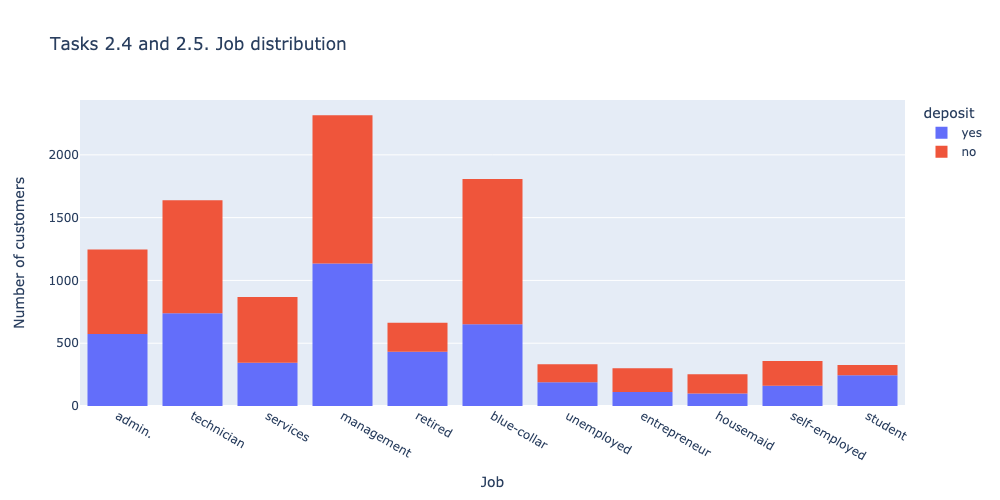

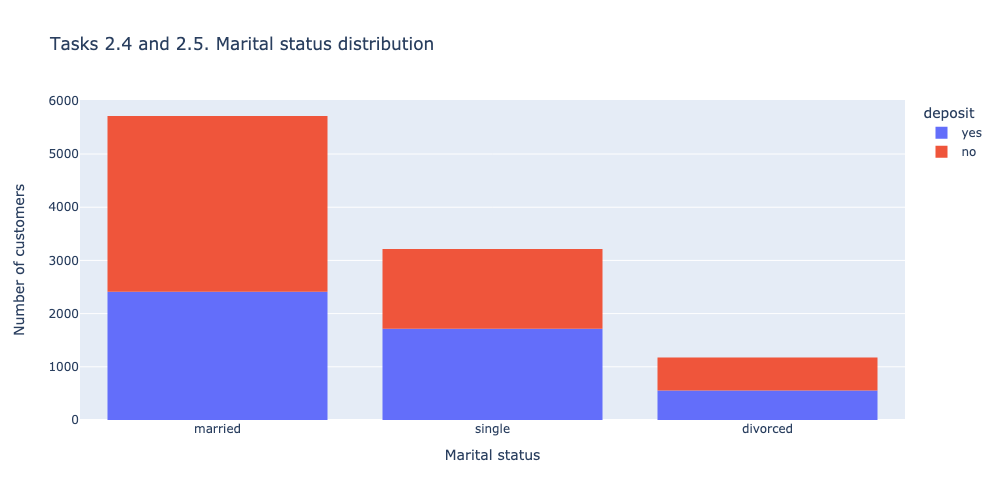

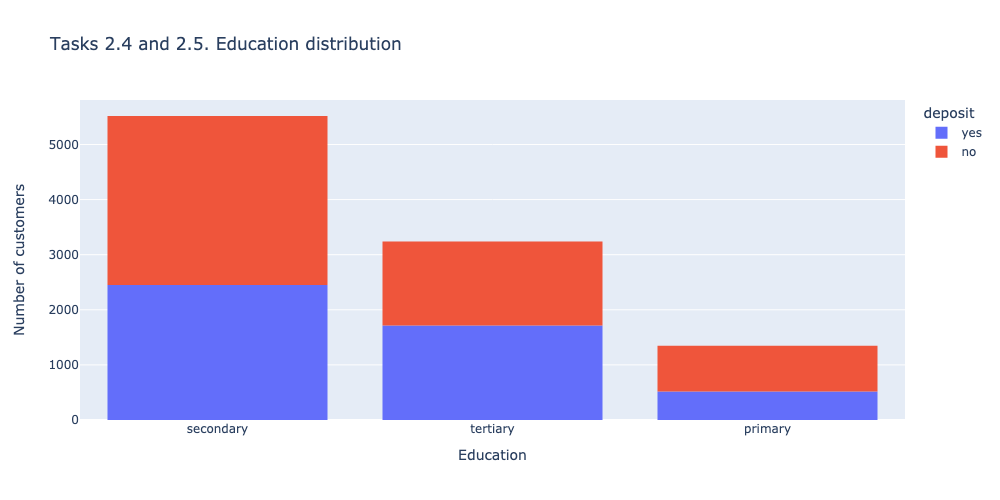

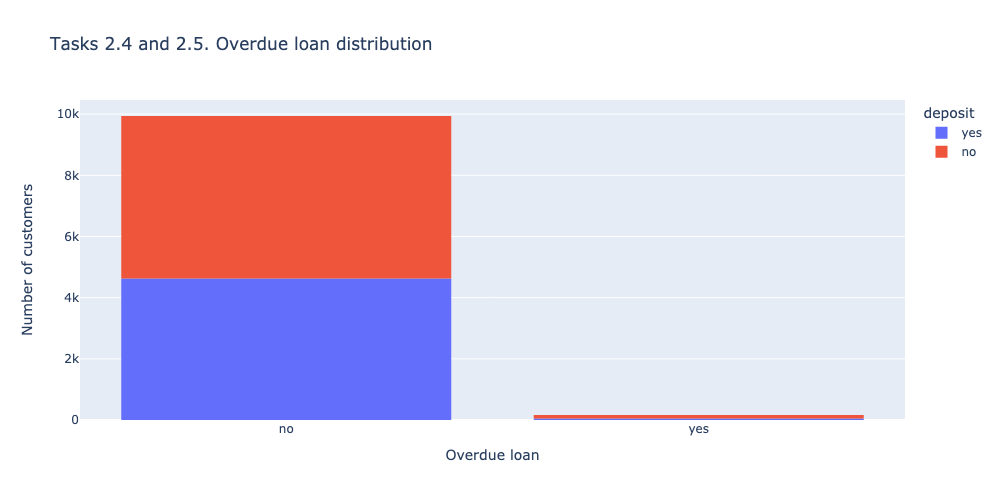

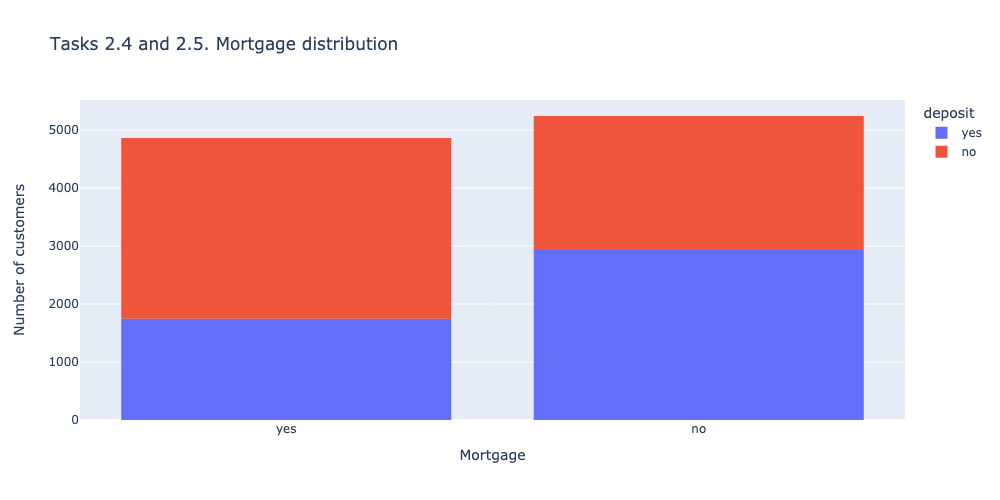

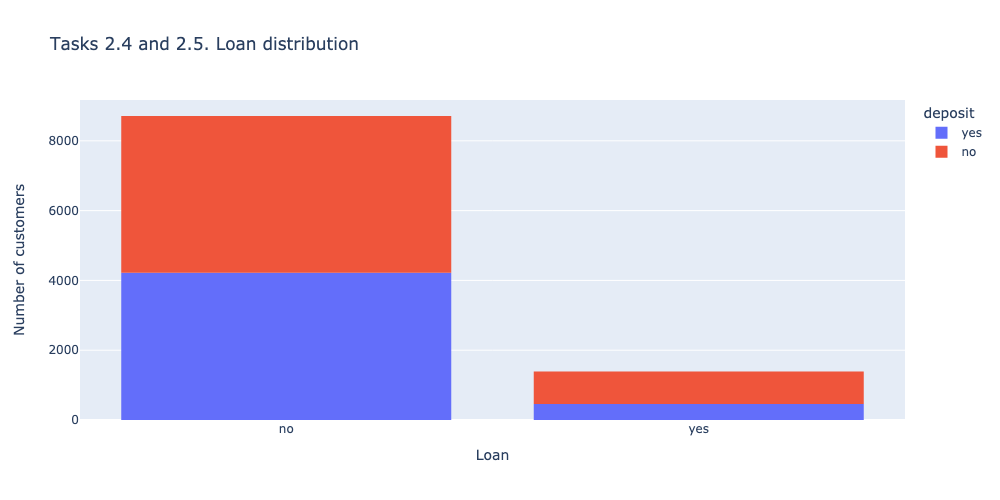

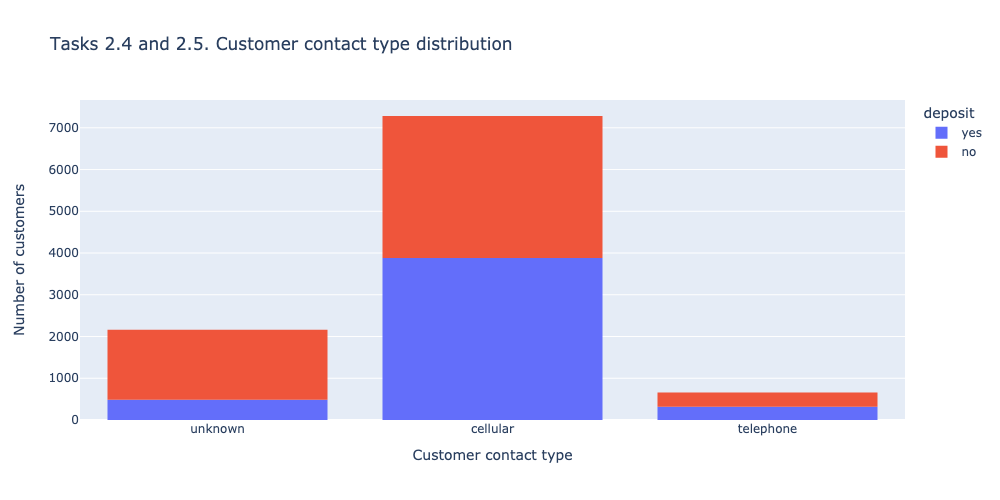

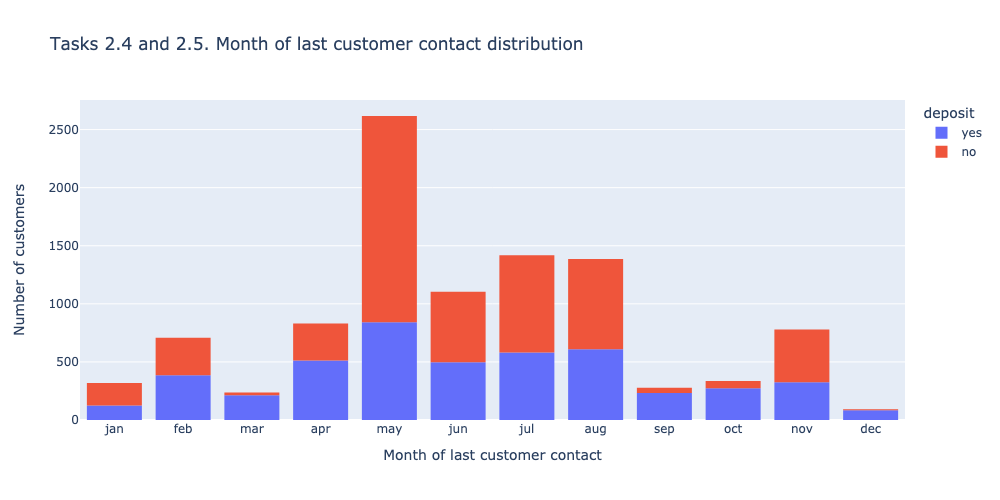

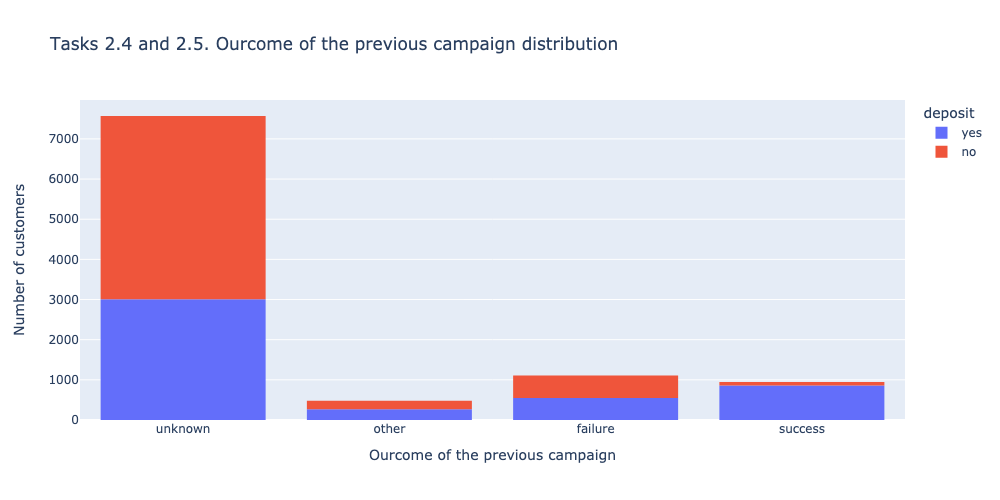

In [416]:
# Calculate quantitative statistics for categorical features. Interpret the results.
print('Quantitative statistics of the categorical features:')
print(df.describe(include=['object']))

show_histogram(df, 'job', 'Job')
show_histogram(df, 'marital', 'Marital status')
show_histogram(df, 'education', 'Education')
show_histogram(df, 'default', 'Overdue loan')
show_histogram(df, 'housing', 'Mortgage')
show_histogram(df, 'loan', 'Loan')
show_histogram(df, 'contact', 'Customer contact type')
show_histogram(df, 'month', 'Month of last customer contact', 
    {'month': ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']}
)
show_histogram(df, 'poutcome', 'Ourcome of the previous campaign')

* Feature 'job': there are in total 11 different types of jobs present in the data. Based on the chart we can observe that the retired and the students are a little more likely to open a deposit, where as services and enterpreneurs are a little less likely to open a deposit.
* Feature 'marital': there are three diffferent marital types present in the data. Based on the chart we can see that married people are a little less likely to open a deposit.
* Feature 'education': three different education levels are present in the data. Based on the chart we can assume that people with primary and secondary education are a little less likely to open a deposit.
* Featufe 'default': there are only two options ('yes' and 'no'). Based on the chart we can see that those customers who have an overdue loan are unlikely to open a deposit.
* Feature 'housing': there are only two options ('yes' and 'no'). Based on the chart we can see that those customers who have a mortgage are less likely to open a deposit.
* Feature 'loan': there are only two options ('yes' and 'no'). Based on the chart we can see that those customers who have a loan a less likely to open a deposit.
* Feature 'contact': three contact options are present in the data. 'unknown' contact option assumes a lower likelihood of opening a deposit, but it is hard to evaluate what is understood under 'unknown'.
* Feature 'month': all twelve months are present in the data. Based on the chart we can make an assumption that the customers contacted in March, September, October and December are more likely to open a deposit.
* Feature 'poutcome': based on the chart we can conclude that succuss in the previous campaign raises the success chance in the current campaign.

### Task 6

In [417]:
# Find out for which of the outcomes of the previous campaign, in the current campaign the success prevails over failure.
df.groupby(['poutcome', 'deposit'])['deposit'].agg('count')

poutcome  deposit
failure   no          562
          yes         547
other     no          216
          yes         265
success   no           84
          yes         861
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

Success in the previous campaign raises the chance of success in the current campaign.

### Task 7

In [418]:
# Find out in which month the customers most frequently refused to open a deposit.
dep_yes = df[df['deposit'] == 'yes'].groupby(['month', 'deposit'])['deposit'].agg('count').unstack()
dep_ratio = df[df['deposit'] == 'no'].groupby(['month', 'deposit'])['deposit'].agg('count').unstack()
dep_ratio['yes'] = dep_yes['yes']
dep_ratio['ratio'] = dep_ratio['no'] / dep_ratio['yes']
dep_ratio.sort_values('ratio')

deposit,no,yes,ratio
month,,,
dec,9,84,0.107143
mar,24,213,0.112676
sep,46,232,0.198276
oct,62,273,0.227106
apr,317,513,0.617934
feb,323,386,0.836788
jun,606,498,1.216867
aug,775,610,1.270492
nov,456,324,1.407407


The highest deposit refusal rate was in may.

### Task 8

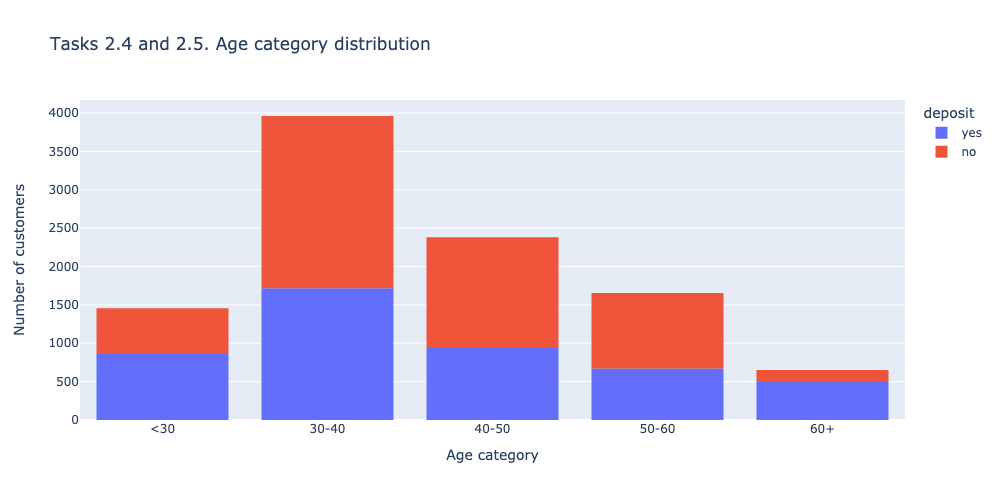

In [419]:
# Split the customers to age groups and determine which age groups are more likely to open a deposit.


def get_age_category(x):
    if x < 30:
        return '<30'
    elif x >= 30 and x < 40:
        return '30-40'
    elif x >= 40 and x < 50:
        return '40-50'
    elif x >= 50 and x < 60:
        return '50-60'
    else:
        return '60+'


df['age_cat'] = df['age'].apply(lambda x: get_age_category(x))

show_histogram(df, 'age_cat', 'Age category', 
    {'age_cat': ['<30', '30-40', '40-50', '50-60', '60+']}
)

### Tasks 9 and 10

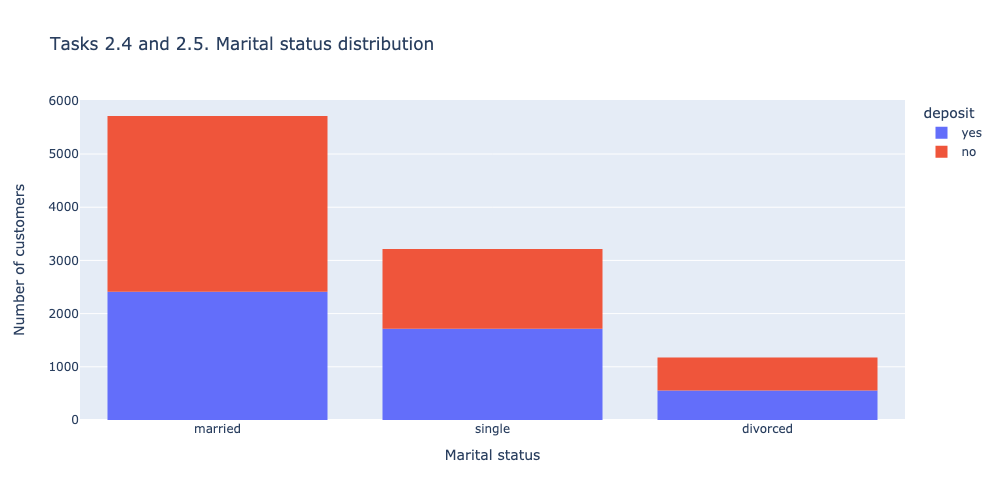

In [420]:
# Build a diagram to visualize the amount of opened and not opened deposits based on the marital status.
show_histogram(df, 'marital', 'Marital status')

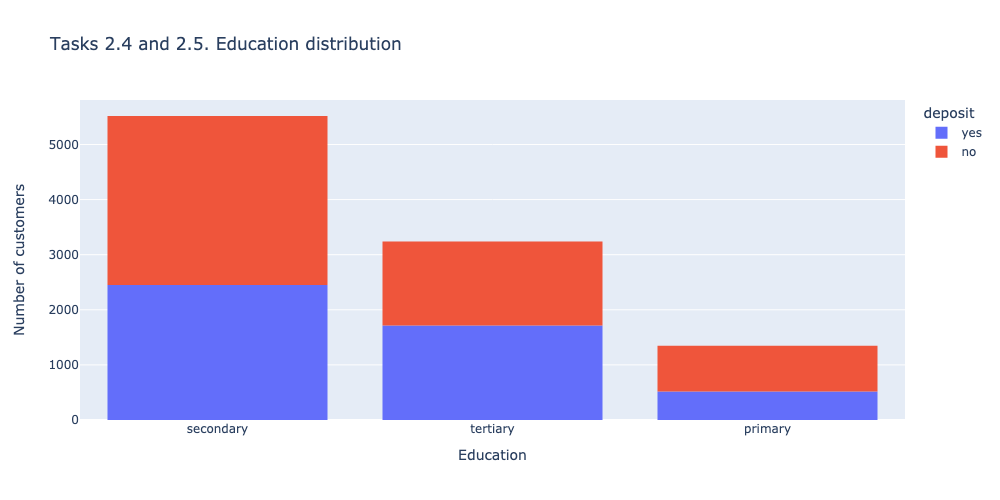

In [421]:
# Build a diagram to visualize the amount of opened and not opened deposits based on the education level.
show_histogram(df, 'education', 'Education')

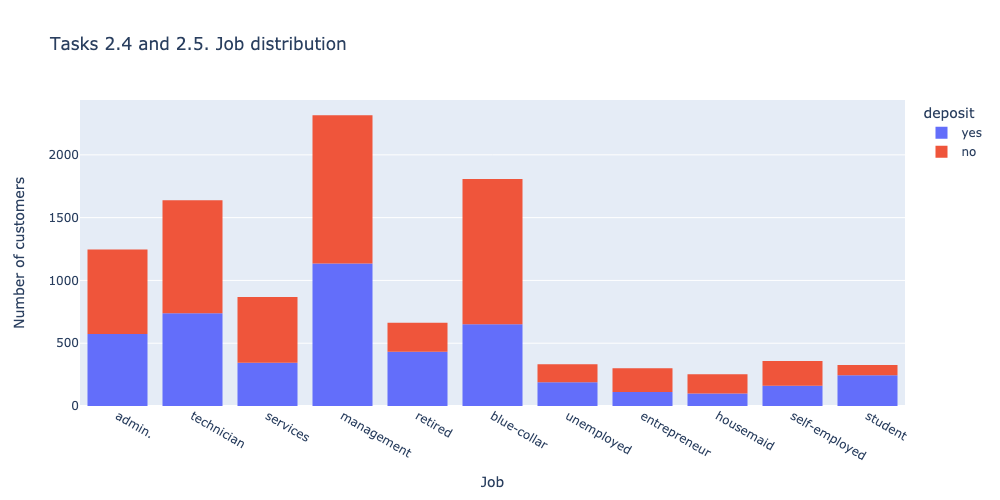

In [422]:
# Build a diagram to visualize the amount of opened and not opened deposits based on the job type.
show_histogram(df, 'job', 'Job')

### Task 11

In [423]:
# Visualize a pivot table to determine the  marital status and the education level of the customers 
# who mostly open or not open a deposit.

dep_yes = df[df['deposit'] == 'yes'][['education', 'marital']]
fig = px.density_heatmap(
    dep_yes, 
    x='education', 
    y='marital',
    title='Deposits opened by marital status and education level',
    width=700,
    height=500
).update_layout(
    yaxis_title='Marital status',
    xaxis_title='Education level'    
)
fig.show()

dep_no = df[df['deposit'] == 'no'][['education', 'marital']]
fig = px.density_heatmap(
    dep_no, 
    x='education', 
    y='marital',
    title='Deposits not opened by marital status and education level',
    width=700,
    height=500
).update_layout(
    yaxis_title='Marital status',
    xaxis_title='Education level'    
)
fig.show()

Surprisingly for both opening and not opening deposits the married customers with a secondary education have the highest frequency.

## Part 3: data transformation

### Task 1

In [424]:
# Transform the level of education and categorized age.
le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])

print(f'Education level sum for validation: {sum(df['education'])}')

df['age_cat'] = le.fit_transform(df['age_cat'])

Education level sum for validation: 11995


### Tasks 2 and 3

In [425]:
# Transform binary features to be presented by 0 and 1.


def transform_yes_no(df, feature):
    df[feature] = df[feature].apply(lambda x: 1 if x == 'yes' else 0)

    
transform_yes_no(df, 'deposit')
print(f'Standard deviation of \'deposit\': {df['deposit'].std():.3f}')

transform_yes_no(df, 'default')
transform_yes_no(df, 'housing')
transform_yes_no(df, 'loan')

mean_default = df['default'].mean()
mean_housing = df['housing'].mean()
mean_loan = df['loan'].mean()
mean_total = mean_default + mean_housing + mean_loan
print(f'Sum of mean \'default\', \'housing\' and \'loan\': {mean_total:.3f}')

Standard deviation of 'deposit': 0.499
Sum of mean 'default', 'housing' and 'loan': 0.635


### Task 4

In [426]:
# Create dummy features for the remaining categorical features.
df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'])

### Tasks 5 and 6

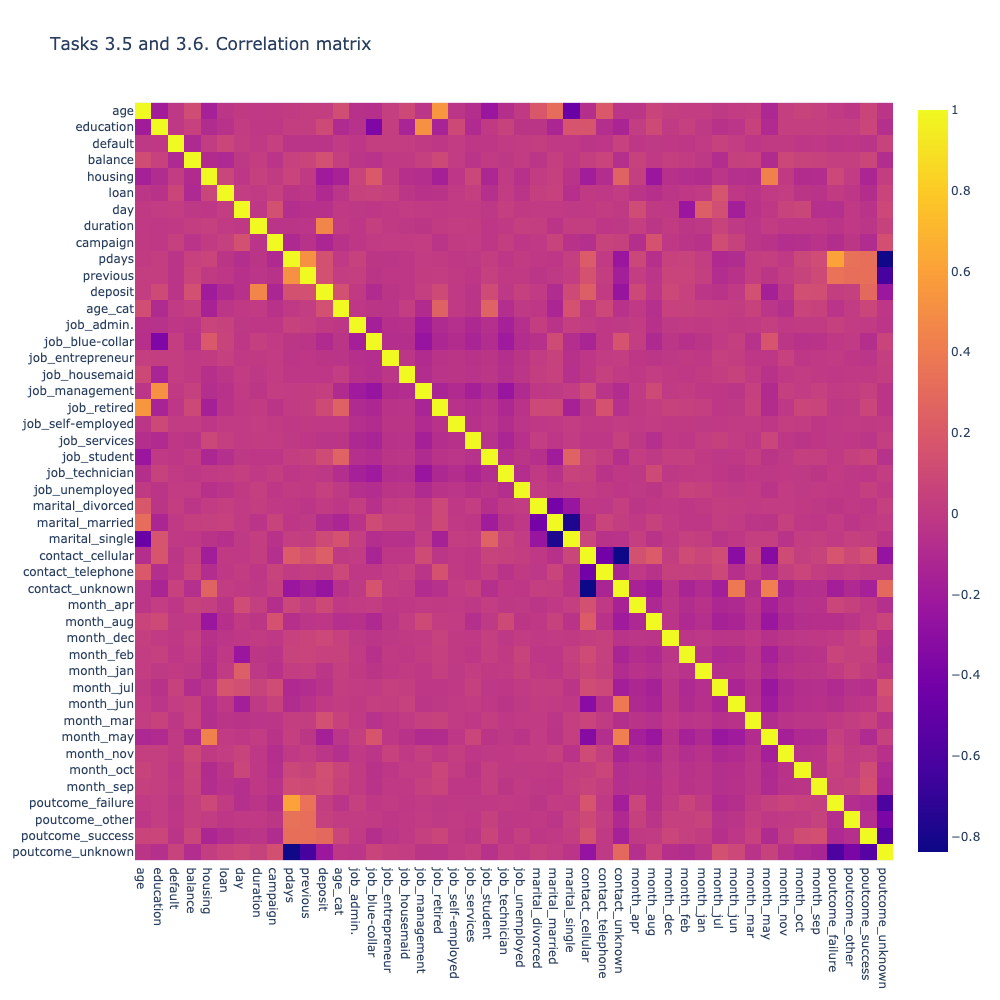

Correlations abs >= 0,7:
df(pdays, poutcome_unknown): -0.82403133930182
df(marital_married, marital_single): -0.7790378984346249
df(contact_cellular, contact_unknown): -0.8378850005984578


In [427]:
# Build a correlation matrix and evaluate dada for multi-collinearity
fig = px.imshow(
    df.corr(),
    width=1000,
    height=1000,
    title='Tasks 3.5 and 3.6. Correlation matrix'
)
fig.show('png')

print('Correlations abs >= 0,7:')
corr = df.corr().values
for i in range(len(df.columns)):
    for j in range(i + 1, len(df.columns)):
        if abs(corr[i, j]) >= 0.7:
            print(f'df({df.columns[i]}, {df.columns[j]}): {corr[i, j]}')

### Tasks 7 and 8

In [428]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [429]:
print(f'Test data size: {X_test.shape[0]}')
print(f'Mean test target feature value: {y_test.mean():.2f}')

Test data size: 3335
Mean test target feature value: 0.46


### Task 9

In [430]:
# Select 15 most important features using SelectKBest
skb = SelectKBest(f_classif, k=15)
skb.fit_transform(X_train, y_train)

print('15 most important features:')
skb.get_feature_names_out()

X_train = X_train[skb.get_feature_names_out()]
X_test = X_test[skb.get_feature_names_out()]

15 most important features:


### Task 10

In [431]:
# нормализуйте данные с помощью minmaxsxaler
mms = preprocessing.MinMaxScaler()
mms.fit(X_train)
X_train = pd.DataFrame(mms.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(mms.transform(X_test), columns=X_test.columns)

print(f'Normalized balance mean: {X_test['balance'].mean():.2f}')

Normalized balance mean: 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [4]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna